In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, make_scorer
from scipy.spatial import distance_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import optuna
from optuna.integration import LightGBMPruningCallback
import lightgbm as lgbm
import time
from sklearn.metrics import (confusion_matrix,roc_auc_score,roc_curve,auc)
from sklearn.metrics import log_loss, make_scorer
from scipy.spatial import distance_matrix

In [37]:
def roc_to_img(y_true, y_pred):

    _fpr, _tpr, _threshold = roc_curve(y_true, y_pred)
    _roc_auc = auc(_fpr, _tpr)

    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(_fpr, _tpr, 'b', label='AUC = %0.4f' % _roc_auc)
    plt.title('Receiver Operating Characteristic')

    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    _optimal_idx = np.argmax(_tpr - _fpr)
    _optimal_threshold = _threshold[_optimal_idx]

    _optimal_threshold = round(_optimal_threshold,
                               2)

    return _roc_auc, _optimal_threshold

def calculate_rates(y_true, y_pred, thr):
    
    _y_pred_new = np.where(y_pred > thr,
                           1,
                           0)

    y_true = np.array(y_true)

    _tp_rate = round(sum(np.where(y_true == 1,
                                  np.where(_y_pred_new == 1,
                                           1,
                                           0),
                                  0)) / sum(y_true == 1),
                     2)

    _fp_rate = round(sum(np.where(y_true == 0,
                                  np.where(_y_pred_new == 1,
                                           1,
                                           0),
                                  0)) / sum(y_true == 0),
                     4)

    _bad_rate = round(sum(np.where(y_true == 1,
                                   np.where(_y_pred_new == 0,
                                            1,
                                            0),
                                   0)) / sum(_y_pred_new == 0),
                      4)
    
    print("TP Rate : ", _tp_rate)
    print("FP Rate : ", _fp_rate)
    print("Bad Rate : ", _bad_rate)

    return _y_pred_new, _tp_rate, _fp_rate, _bad_rate

In [4]:
# X Train
train = pd.read_csv("train_proje.csv",  sep=",")
x_test = pd.read_csv("test_proje.csv",  sep=",")
test_sample= pd.read_csv("test_ids_in_prediction.csv", sep='|',  encoding='latin-1')

list_array = test_sample.to_numpy()

x_test_sample = x_test[x_test["unique_id"].isin(list_array)]

In [5]:
#Check all type train
class3 = (train.iloc[:, -1] != 'train')*1
print(sum(class3))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])

print(train['gender'])

train['time_stamp'] = pd.to_datetime(train['time_stamp'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')
train['time_hour'] = train['time_stamp'].dt.hour


x_test_sample['time_stamp'] = pd.to_datetime(x_test_sample['time_stamp'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')
x_test_sample['time_hour'] = x_test_sample['time_stamp'].dt.hour


means = train.groupby('user_action')['gender'].mean()
train['user_action'] = train['user_action'].map(means)
x_test_sample['user_action'] = x_test_sample['user_action'].map(means)

means = train.groupby('businessunit')['gender'].mean()
train['businessunit'] = train['businessunit'].map(means)
x_test_sample['businessunit'] = x_test_sample['businessunit'].map(means)

means = train.groupby('product_gender')['gender'].mean()
train['product_gender'] = train['product_gender'].map(means)
x_test_sample['product_gender'] = x_test_sample['product_gender'].map(means)



train_drop=train.drop(columns=['time_stamp', 'contentid','product_name','brand_name','Level1_Category_Name','Level2_Category_Name','Level3_Category_Name','type'], axis=1)
test_drop=x_test_sample.drop(columns=['time_stamp', 'contentid','product_name','brand_name','Level1_Category_Name','Level2_Category_Name','Level3_Category_Name','type'], axis=1)



0
0          0
1          0
2          0
3          0
4          0
          ..
5493263    1
5493264    1
5493265    1
5493266    1
5493267    1
Name: gender, Length: 5493268, dtype: int32


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
cv = CountVectorizer(max_features = 15)
cv2 = CountVectorizer(max_features = 15)
train['product_name'] = train['product_name'].fillna(" ")
train['brand_name'] = train['brand_name'].fillna(" ")
X_product = cv.fit_transform(train['product_name']).toarray()
X_brand = cv2.fit_transform(train['brand_name']).toarray()
X_product = pd.DataFrame(X_product)
X_brand = pd.DataFrame(X_brand)
X_brand.columns = [f'brandcol{i}' for i in range(0,len(X_brand.T))]

In [8]:
x_test_sample['product_name'] = x_test_sample['product_name'].fillna(" ")
x_test_sample['brand_name'] = x_test_sample['brand_name'].fillna(" ")

X_test_product = cv.transform(x_test_sample['product_name']).toarray()
X_test_brand = cv2.transform(x_test_sample['brand_name']).toarray()
X_test_product = pd.DataFrame(X_test_product)
X_test_brand = pd.DataFrame(X_test_brand)
X_test_brand.columns = [f'brandcol{i}' for i in range(0,len(X_test_brand.T))] 

In [9]:
X_concat =pd.concat([train_drop, X_product,X_brand],  axis=1)
X_concat =X_concat.iloc[:,1:]

In [10]:
X_test_concat =pd.concat([test_drop, X_test_product,X_test_brand],  axis=1)
X_test_concat =X_test_concat.iloc[:,1:]

In [11]:
print(train)

                 time_stamp   contentid  user_action  sellingprice  \
0                       NaT  39918893.0     0.065723       3099.00   
1                       NaT   3558544.0     0.065723       3079.00   
2                       NaT  31292729.0     0.065723       3999.00   
3       2020-12-05 16:28:00   6363103.0     0.125061       2544.00   
4       2020-12-02 22:26:59  39918893.0     0.125061       3099.00   
...                     ...         ...          ...           ...   
5493263 2020-12-09 11:41:59  31440796.0     0.160625         89.50   
5493264 2020-12-09 00:10:16  54677237.0     0.160625         99.99   
5493265 2020-12-09 11:40:57   2699559.0     0.160625        169.00   
5493266                 NaT  34981546.0     0.065723        248.48   
5493267 2020-12-09 10:44:35  34981546.0     0.125061        248.48   

                                              product_name  brand_id  \
0        PerfectCare 600 EW6F449ST A+++ 9 KG 1400 Devir...    8511.0   
1        WW90J5

In [12]:
print(X_concat)

         sellingprice  brand_id  businessunit  product_gender  category_id  \
0             3099.00    8511.0      0.272579        0.151450       1272.0   
1             3079.00    3228.0      0.272579             NaN       1272.0   
2             3999.00   10989.0      0.272579        0.151450       1276.0   
3             2544.00   10989.0      0.272579             NaN       1272.0   
4             3099.00    8511.0      0.272579        0.151450       1272.0   
...               ...       ...           ...             ...          ...   
5493263         89.50   30457.0      0.211069        0.151450        864.0   
5493264         99.99  978383.0      0.570413        0.470852       1186.0   
5493265        169.00    8171.0      0.211069        0.151450        864.0   
5493266        248.48   93397.0      0.140228        0.470852        975.0   
5493267        248.48   93397.0      0.140228        0.470852        975.0   

         Level1_Category_Id  Level2_Category_Id  Level3_Categor

In [13]:
q25_data = X_concat.groupby(['unique_id']).quantile(0.25)
q75_data = X_concat.groupby(['unique_id']).quantile(0.75)
mean = X_concat.groupby(['unique_id']).mean()
option_2=(q75_data+q25_data+mean)/3
option_2

,sellingprice,brand_id,businessunit,product_gender,category_id,Level1_Category_Id,Level2_Category_Id,Level3_Category_Id,gender,time_hour,...,brandcol5,brandcol6,brandcol7,brandcol8,brandcol9,brandcol10,brandcol11,brandcol12,brandcol13,brandcol14
unique_id,,,,,,,,,,,,,,,,,,,,,
1,112.998954,61768.054009,0.129104,0.145483,1429.215213,939.982272,869.233972,1181.883323,0.0,11.241093,...,0.001440,0.004527,0.014815,0.000000,0.001235,0.000000,0.002058,0.000000,0.014815,0.004527
2,121.377652,48010.564896,0.094103,0.098818,1219.593428,671.603745,1395.410011,1171.330276,0.0,15.117363,...,0.007003,0.000382,0.029539,0.000255,0.004456,0.008149,0.002037,0.000255,0.029539,0.000382
3,198.018832,17295.436811,0.090940,0.053550,865.703986,538.132316,1870.700594,893.177269,0.0,17.345518,...,0.000000,0.000000,0.470389,0.000000,0.000000,0.000000,0.000000,0.000000,0.470389,0.000000
4,219.572958,57772.373535,0.108257,0.062563,1007.010384,872.498209,1767.441064,982.350641,0.0,15.123366,...,0.000486,0.002489,0.003825,0.000425,0.002854,0.008804,0.000486,0.000000,0.003825,0.002489
5,118.082417,25966.406075,0.063604,0.094476,757.806642,827.649170,1663.762090,912.787687,0.0,15.846085,...,0.000081,0.000567,0.021709,0.000081,0.000000,0.021061,0.000729,0.000000,0.021709,0.000567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,925.000000,23155.000000,0.262792,0.151450,2604.000000,2859.000000,2469.000000,797.000000,0.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7992,87.000000,214948.000000,0.163814,0.151450,1714.000000,2859.000000,687.000000,1636.000000,0.0,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7995,4699.000000,2765.000000,0.302382,NaN,2696.000000,1071.000000,1213.000000,2695.000000,1.0,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
q25_data_test = X_test_concat.groupby(['unique_id']).quantile(0.25)
q75_data_test = X_test_concat.groupby(['unique_id']).quantile(0.75)
mean = X_test_concat.groupby(['unique_id']).mean()
option_2_test=(q75_data_test+q25_data_test+mean)/3
option_2_test

,sellingprice,brand_id,businessunit,product_gender,category_id,Level1_Category_Id,Level2_Category_Id,Level3_Category_Id,gender,time_hour,...,brandcol5,brandcol6,brandcol7,brandcol8,brandcol9,brandcol10,brandcol11,brandcol12,brandcol13,brandcol14
unique_id,,,,,,,,,,,,,,,,,,,,,
9,173.526771,18713.560348,0.085449,0.062929,878.035439,568.547388,2060.992102,952.541110,NaN,20.012756,...,0.021805,0.000808,0.453261,0.002423,0.004442,0.016354,0.002019,0.002423,0.453261,0.000808
18,80.264474,49262.183008,0.089833,0.067643,910.425655,572.423496,1967.617921,962.304021,NaN,14.576667,...,0.033039,0.001472,0.436147,0.008047,0.010402,0.004220,0.004514,0.009192,0.436147,0.001472
21,200.800823,25928.801939,0.131055,0.104666,962.314097,517.613881,1621.595876,968.484918,NaN,17.222163,...,0.011542,0.012773,0.053401,0.000000,0.005694,0.001847,0.004309,0.000000,0.053401,0.012773
25,179.700344,196286.698223,0.098820,0.100334,939.479779,677.887561,1462.180453,900.024203,NaN,15.782090,...,0.014373,0.012844,0.049847,0.000000,0.000612,0.000000,0.001223,0.000917,0.049847,0.012844
31,160.800237,81119.871064,0.109567,0.101321,1330.990946,844.346914,1036.050806,1228.377269,NaN,13.790361,...,0.001656,0.002342,0.040102,0.000081,0.001333,0.003069,0.004685,0.000081,0.039859,0.002342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7982,89.950000,1042.000000,0.053585,0.052252,601.000000,522.000000,2871.000000,601.000000,NaN,21.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7990,729.000000,15.000000,0.315844,0.470852,425.000000,403.000000,420.000000,425.000000,NaN,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7993,0.000000,3330.000000,0.315844,0.151450,448.000000,368.000000,435.000000,448.000000,NaN,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
y=option_2['gender']

In [16]:
option_2=option_2.drop(columns=['gender'], axis=1)
option_2_test=option_2_test.drop(columns=['gender'], axis=1)

In [17]:
option_2 = option_2.fillna(0)
option_2_test = option_2_test.fillna(0)

In [32]:
print(y)

unique_id
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
7991    0.0
7992    0.0
7995    1.0
7996    0.0
7997    0.0
Name: gender, Length: 5618, dtype: float64


In [35]:
print(sum(y==1)*1)

1939


In [36]:
print(sum(y==0)*1)

3679


In [18]:
def objective_2(trial):
    train_data_2 = lgbm.Dataset(option_2, label=y) 
    params_2={
        "seed": 2612,
        "boosting_type":"gbdt",
        "metric":"auc",
        "num_iterations": trial.suggest_categorical("num_iterations", [100, 300, 500,750, 1000,1500]),
        "max_depth" :  trial.suggest_int("max_depth", 3, 15),
        "num_leaves" : trial.suggest_int('num_leaves', 20, 2**14),
        "subsample" : trial.suggest_float('subsample', 0.2, 1.0) ,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_threads" : trial.suggest_int("num_threads", 5, 135),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=10),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=10),
        "objective": "binary",
         "is_unbalance" : True,
        "early_stopping_rounds" : 100,
        'verbose': -1
    }
    gbm_2 = lgbm.cv(params_2,
           train_set=train_data_2, nfold=10,early_stopping_rounds=30,
                    verbose_eval=False)
    auc = np.mean((gbm_2["auc-mean"]))
    return auc 


In [19]:

import sklearn.datasets
import sklearn.metrics
sampler= optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler,pruner=optuna.pruners.MedianPruner(
        n_startup_trials=2, n_warmup_steps=5, interval_steps=3
    ),direction="maximize")
study.optimize(objective_2, n_trials=25)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2022-01-24 13:34:20,140] A new study created in memory with name: no-name-7e2de2fd-180a-4c41-aa6e-716d262b8e39
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated an

C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-01-24 13:35:30,061] Trial 6 finished with value: 0.8555749806599009 and parameters: {'num_iterations': 500, 'max_depth': 15, 'num_leaves': 6411, 'subsample': 0.49801913510670764, 'learning_rate': 0.08910947396313056, 'num_threads': 78, 'lambda_l1': 40, 'lambda_l2': 30}. Best is trial 2 with value: 0.857518373983428.
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_roun

C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-01-24 13:36:54,054] Trial 13 finished with value: 0.8

C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-01-24 13:38:36,873] Trial 19 finished with value: 0.8547418056699242 and parameters: {'num_iterations': 1000, 'max_depth': 9, 'num_leaves': 2561, 'subsample': 0.5709013364544913, 'learning_rate': 0.031908156549158274, 'num_threads': 99, 'lambda_l1': 50, 'lambda_l2': 30}. Best is trial 15 with value: 0.8600254324704567.
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_r

Number of finished trials: 25
Best trial:
  Value: 0.8600254324704567
  Params: 
    num_iterations: 1000
    max_depth: 9
    num_leaves: 2382
    subsample: 0.41458860443633594
    learning_rate: 0.05191656545400322
    num_threads: 95
    lambda_l1: 20
    lambda_l2: 10


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(option_2, y, test_size = 0.15, random_state = 1,stratify=y)

In [21]:
train_data = lgbm.Dataset(X_train,y_train)
valid_data = lgbm.Dataset(X_test,y_test)

config_params = {
    "classification" : {
                "seed": 2612,
                "boosting_type":"gbdt",
                "metric":"auc",
                "colsample_bytree" : 0.9,
                "objective": "binary",
                 "is_unbalance" : True,
                "early_stopping_rounds" : 100,

        }
   
    
   }
config_params["classification"].update(study.best_params)
config_params["classification"]["n_estimators"] = study.best_params["num_iterations"]#It is equal to 1000
lgb_model =lgbm.train(config_params["classification"],train_data,valid_sets=[train_data,valid_data],verbose_eval=10)
score = lgb_model.best_score
print(score)


C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Public\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1648, number of negative: 3127
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9938
[LightGBM] [Info] Number of data points in the train set: 4775, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345131 -> initscore=-0.640512
[LightGBM] [Info] Start training from score -0.640512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[100]	training's auc: 0.902273	valid_1's auc: 0.85751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	training's auc: 0.904228	valid_1's auc: 0.85769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

In [41]:
y_pred = lgb_model.predict(option_2_test)
print(y_pred)

[0.04864369 0.0638848  0.06578682 ... 0.6198926  0.53479867 0.70944813]


In [43]:
y_pred_valid = lgb_model.predict(X_test)
print(y_pred_valid)

[0.03152422 0.67983172 0.10188286 0.89460371 0.77986132 0.24580217
 0.61668432 0.86120847 0.31352364 0.78375276 0.86119683 0.90725706
 0.62451624 0.85150853 0.45877368 0.86973016 0.05990427 0.03343129
 0.8247297  0.04916312 0.30416483 0.76311845 0.35448933 0.29465788
 0.05606163 0.58646111 0.29202666 0.7955968  0.0513276  0.07105474
 0.57786032 0.11812696 0.762615   0.78470522 0.03954645 0.68121991
 0.64551076 0.19471481 0.57799565 0.03332898 0.10249173 0.09966065
 0.75562634 0.81695876 0.20084765 0.03207001 0.26733297 0.07718965
 0.08118316 0.80668402 0.73722404 0.29865514 0.80157527 0.02312591
 0.04004259 0.74197867 0.02602633 0.44963742 0.05159072 0.0287355
 0.23085283 0.49887023 0.7970472  0.3885993  0.40671466 0.24432758
 0.40292763 0.06853171 0.59695315 0.06689008 0.78989242 0.09727748
 0.77182182 0.03497786 0.61811505 0.1013866  0.79734004 0.03405014
 0.07811748 0.53179208 0.69707567 0.6878904  0.43470551 0.55114532
 0.07229392 0.57021647 0.1005623  0.03304848 0.02338283 0.11803

0.8578396583495194 0.51


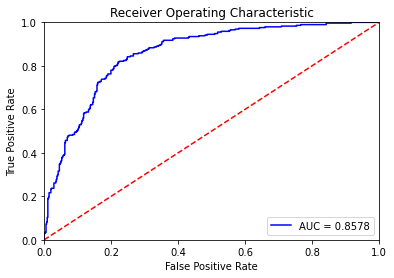

In [44]:
auroc ,thr_test = roc_to_img(y_test,y_pred)
print(auroc ,thr_test)

In [45]:
y_pred_new, tp_rate, fp_rate,bad_rate = calculate_rates(y_test, y_pred, thr_test)

TP Rate :  0.82
FP Rate :  0.221
Bad Rate :  0.1097


In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_new)

array([[430, 122],
       [ 53, 238]], dtype=int64)

In [26]:
import shap

In [28]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


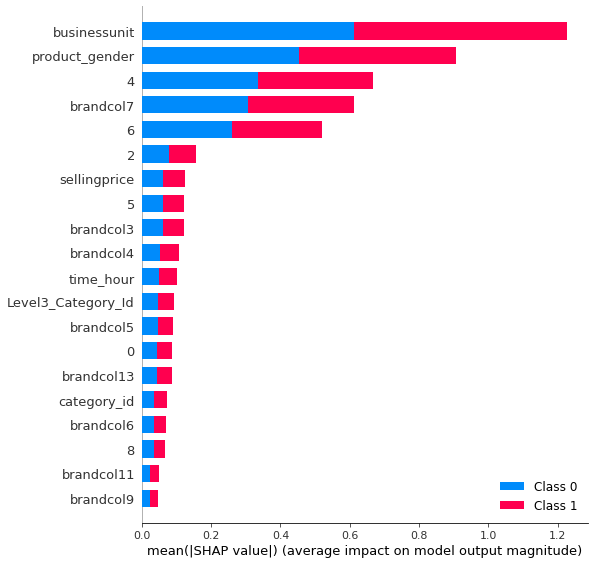

In [29]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

In [ ]:
y_pred_f =[]
for x in y_pred:
    y_pred_f.append(1-x)
print(y_pred_f[1])

In [ ]:
deneme =""

for x in y_pred_f:
    deneme=deneme+","+"{:.4f}".format(x)       
deneme = deneme[1:]
print(deneme)